In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.shufflenet import ShuffleNet
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/shufflenet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

6


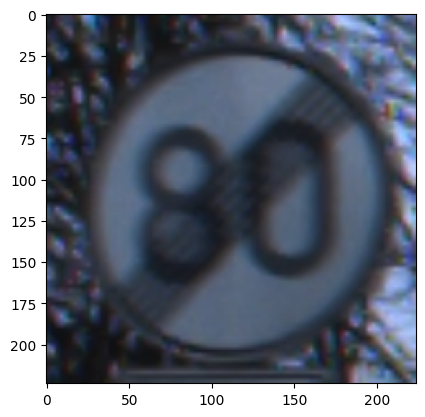

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = ShuffleNet(output_size=num_class, groups=3).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
ShuffleNet                                              --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 648
│    │    └─BatchNorm2d: 3-2                            48
│    │    └─ReLU: 3-3                                   --
│    └─MaxPool2d: 2-2                                   --
├─Sequential: 1-2                                       --
│    └─ResBlock: 2-3                                    --
│    │    └─BottleNeck: 3-4                             6,012
│    │    └─AvgPool2d: 3-5                              --
│    └─ResBlock: 2-4                                    --
│    │    └─BottleNeck: 3-6                             10,860
│    │    └─Identity: 3-7                               --
│    └─ResBlock: 2-5                                    --
│    │    └─BottleNeck: 3-8                

# training

In [13]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [11:49<00:00,  1.70s/it]


epoch 1 : 0.008262847156751936


100%|██████████| 416/416 [01:19<00:00,  5.26it/s]


epoch 2 : 0.0025945315811930834


100%|██████████| 416/416 [01:22<00:00,  5.07it/s]


epoch 3 : 0.0007593817226384439


100%|██████████| 416/416 [01:18<00:00,  5.29it/s]


epoch 4 : 0.0003363874851367235


100%|██████████| 416/416 [01:20<00:00,  5.20it/s]


epoch 5 : 0.00020478475436483187


100%|██████████| 416/416 [01:20<00:00,  5.19it/s]


epoch 6 : 0.00018922639770398047


100%|██████████| 416/416 [01:23<00:00,  4.99it/s]


epoch 7 : 0.0001258935415146075


100%|██████████| 416/416 [01:25<00:00,  4.86it/s]


epoch 8 : 0.00010181854836643057


100%|██████████| 416/416 [01:23<00:00,  4.99it/s]


epoch 9 : 6.458196582752425e-05


100%|██████████| 416/416 [01:17<00:00,  5.37it/s]

epoch 10 : 0.00015397942819762333


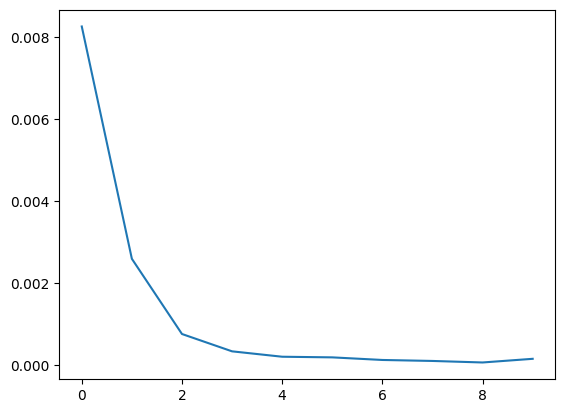

In [18]:
plt.plot(training_loss)

# inference

In [20]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [21]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [22]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [23]:
evaluator = ClassificationEvaluator(num_class, device)

In [24]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:45<00:00,  4.39it/s]

[[  5  41   0 ...   0   0   0]
 [  0 650  30 ...   0   0   0]
 [  0  31 700 ...   0   0   0]
 ...
 [  0   0   0 ...  66   0   0]
 [  0   0   0 ...   0  40  11]
 [  0   0   0 ...   0  11  58]]


In [25]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.08333333333333333
1         : 0.9027777777777778
2         : 0.9333333333333333
3         : 0.7933333333333333
4         : 0.9333333333333333
5         : 0.7936507936507936
6         : 0.7
7         : 0.7955555555555556
8         : 0.8288888888888889
9         : 0.9854166666666667
10        : 0.9863636363636363
11        : 0.8904761904761904
12        : 0.9101449275362319
13        : 0.9958333333333333
14        : 0.9851851851851852
15        : 0.9714285714285714
16        : 0.9866666666666667
17        : 0.9055555555555556
18        : 0.6307692307692307
19        : 0.8166666666666667
20        : 0.45555555555555555
21        : 0.4444444444444444
22        : 0.7583333333333333
23        : 0.6266666666666667
24        : 0.9222222222222223
25        : 0.8583333333333333
26        : 0.9944444444444445
27        : 0.5
28        : 0.6333333333333333
29        : 0.6666666666666666
30        : 0.4
31        : 0.8814814814814815
32        : 1.0
33        : 0.8428571428571429
34  

In [26]:
per_class_acc.mean()

0.752223793928799

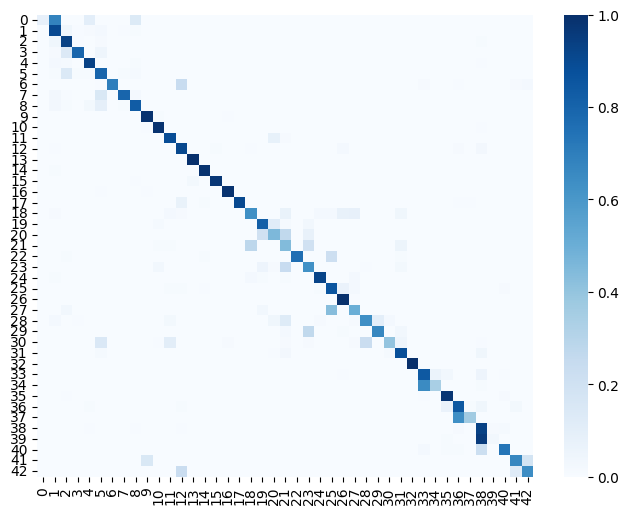

In [27]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [28]:
model_path = artifact_path / f'shufflenet.pth'

In [29]:
torch.save(model.state_dict(), model_path)

In [30]:
get_file_size(model_path)

'3.8MB'

In [31]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>